In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [3]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_image = X_train
X_test_image = X_test
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
input_shape = (28,28,1)
nb_epoch = 20
num_classes = 1
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [4]:
def create_base_network(input_shape):
    model = Sequential()  
    model.add(Conv2D(filters=16,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(Conv2D(filters=36,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Dropout(0.25))  
    model.add(Flatten()) 
    model.add(Dense(128, activation='relu'))  
    return model

In [5]:
base_network = create_base_network(input_shape)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [7]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [8]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
from keras.models import load_model
model = load_model('my_model.h5', custom_objects={'contrastive_loss': contrastive_loss})

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.92%
* Accuracy on test set: 99.83%


In [21]:
def showpre(img_num1,img_num2):
    predtest =  model.predict([X_test[img_num1:img_num1+1],X_test[img_num2:img_num2+1]])
    print(predtest)
    if(predtest<0.5):
        print('true')
    else:
        print('false')
    plt.subplot(121),plt.imshow(X_test_image[img_num1], cmap='gray'),plt.title(img_num1)
    plt.subplot(122),plt.imshow(X_test_image[img_num2], cmap='gray'),plt.title(img_num2)
    plt.show()

[[ 0.04894516]]
true


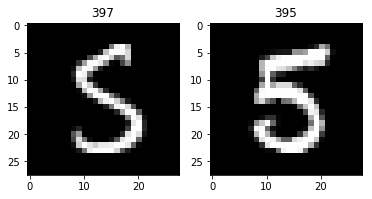

In [22]:
showpre(397,395)